In [1]:
import numpy as np
import numpy.typing as npt
from typing import List, Tuple, Callable
import matplotlib.pyplot as plt

In [2]:
# Case Idea:
#
# Preliminary result | FDA Decision | Probability | Final Price
# GOOD (50%) ($125)  | ACCEPT (75%) | 37.5%       | $150
# GOOD (50%) ($125)  | REJECT (25%) | 12.5%       | $50
# BAD  (50%) ($75)   | ACCEPT (25%) | 12.5%       | $150
# BAD  (50%) ($75)   | REJECT (75%) | 37.5%       | $50

# Start price at $100
# from step 0 to 200, random drift
# from step 200 to 400 increased volatility
# from 400 to 500, increased volatility
# At 500, get preliminary results
# from 500 to 800, decreased volatility
# from 800 to 900, increased volatility
# At 900, FDA releases decision
# From 900 to 1000 convergence to true price (either 50 or 150), low volatility


In [3]:
rng = np.random.default_rng()

In [4]:
def get_base_path(
    initial_price: float,
    up_price: float,
    down_price: float,
    total_ticks: int,
    extra_ticks: int,
    preliminary_probability: float,
    fda_probability: float,
    rng: np.random.Generator,
):
    had_good_preliminary_results = rng.uniform(0, 1.0) < preliminary_probability
    had_fda_accepted = rng.uniform(0, 1.0) < fda_probability if had_good_preliminary_results else rng.uniform(0, 1.0) > fda_probability
    base_bath = initial_price * np.ones(shape=(total_ticks + extra_ticks))
    base_bath[500:900] = (
        fda_probability * up_price + (1-fda_probability) * down_price 
            if had_good_preliminary_results else 
        (1-fda_probability) * up_price + fda_probability * down_price
    )
    base_bath[900:] = up_price if had_fda_accepted else down_price
    return base_bath

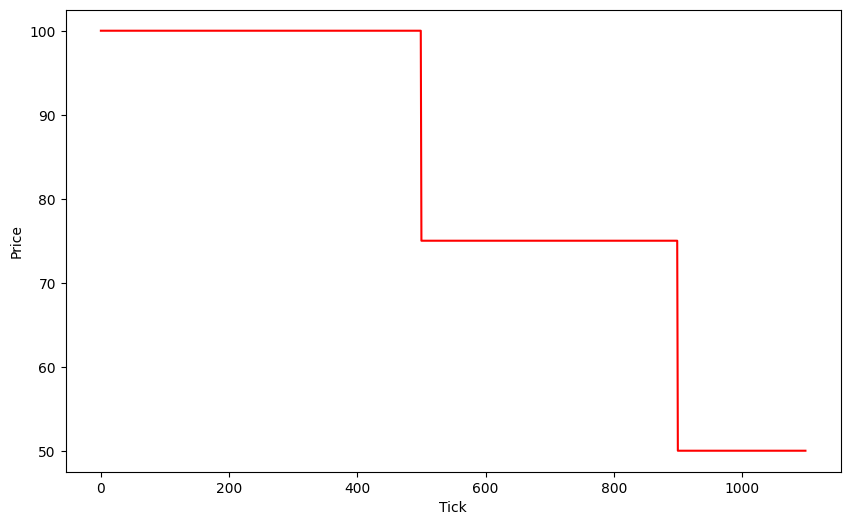

In [5]:
TOTAL_TICKS = 1_000
EXTRA_TICKS = 100
base_path = get_base_path(100, 150, 50, TOTAL_TICKS, EXTRA_TICKS, 0.5, 0.75, rng)
plt.figure(figsize=(10, 6))
plt.plot(base_path, color="red")
plt.xlabel("Tick")
plt.ylabel("Price")
plt.show()

In [6]:
def mean_reverting_follower(
    base_path: npt.NDArray[np.floating],
    volatility_strength_func: Callable[[int, float, float], float], 
    reversion_strength_func: Callable[[int, float, float], float],
    total_ticks: int,
    T: float,
    rng: np.random.Generator
):
    Z = rng.normal(0, 1.0, size=base_path.shape)
    path = np.zeros_like(base_path)
    dt = T / total_ticks
    
    path[0] = base_path[0]
    for tick in range(1, base_path.shape[0]):
        t = dt * tick
        volatility = volatility_strength_func(tick, t, dt)
        reversion_strength = reversion_strength_func(tick, t, dt)
        dP = (
            reversion_strength * (base_path[tick - 1] - path[tick - 1]) * dt + 
            volatility * np.sqrt(dt * path[tick - 1]) * Z[tick - 1]
        )
        path[tick] = path[tick - 1] + dP 
        pass
    return path

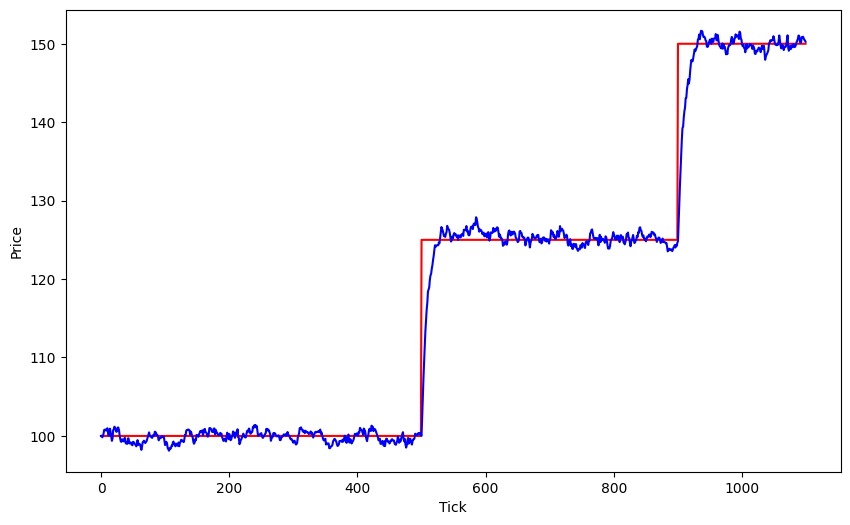

In [7]:
def volatility_strength_func(tick: int, t: float, dt: float):
    return 1

def reversion_strength_func(tick: int, t: float, dt: float):
    return 100

base_path = get_base_path(100, 150, 50, TOTAL_TICKS, EXTRA_TICKS, 0.5, 0.75, rng)
following_path = mean_reverting_follower(
    base_path, volatility_strength_func, reversion_strength_func, TOTAL_TICKS, 1.0, rng
)
plt.figure(figsize=(10, 6))
plt.plot(base_path, color="red")
plt.plot(following_path, color="blue")
plt.xlabel("Tick")
plt.ylabel("Price")
plt.show()

In [8]:
def leaky_mean_reverting_follower(
    base_path: npt.NDArray[np.floating],
    volatility_strength_func: Callable[[int, float, float], float], 
    reversion_strength_func: Callable[[int, float, float], float],
    leak_advance_ticks: int,
    leaky_reversion_strength_func: Callable[[int, float, float], float],
    total_ticks: int,
    T: float,
    rng: np.random.Generator
):
    Z = rng.normal(0, 1.0, size=base_path.shape)
    path = np.zeros(shape=(total_ticks))
    dt = T / total_ticks
    
    path[0] = base_path[0]
    for tick in range(1, total_ticks):
        t = dt * tick
        volatility = volatility_strength_func(tick, t, dt)
        reversion_strength = reversion_strength_func(tick, t, dt)
        leaky_reversion_strength = leaky_reversion_strength_func(tick, t, dt)
        dP = (
            reversion_strength * (base_path[tick - 1] - path[tick - 1]) * dt + 
            leaky_reversion_strength * (base_path[tick + leak_advance_ticks - 1] - path[tick - 1]) * dt + 
            volatility * np.sqrt(dt * path[tick - 1]) * Z[tick - 1]
        )
        path[tick] = path[tick - 1] + dP 
        pass
    return path

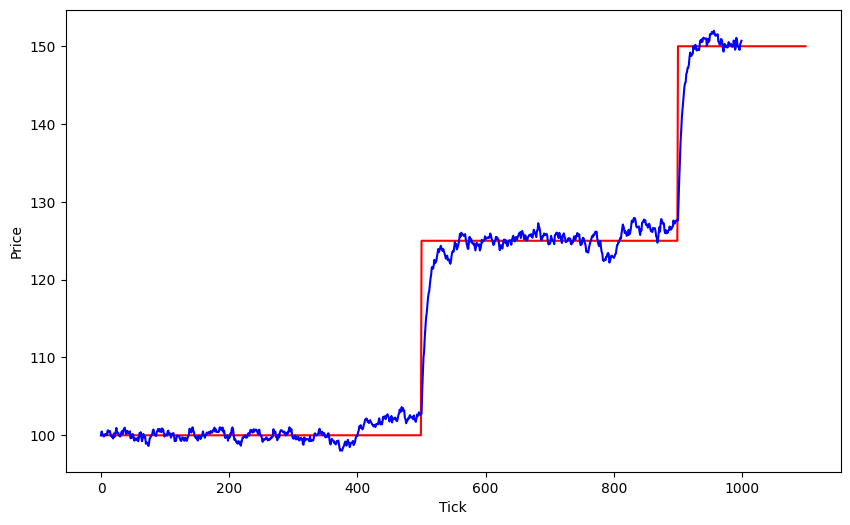

In [9]:
def volatility_strength_func(tick: int, t: float, dt: float):
    return 1

def reversion_strength_func(tick: int, t: float, dt: float):
    return 100

def leaky_reversion_strength_func(tick: int, t: float, dt: float):
    return 10

base_path = get_base_path(100, 150, 50, TOTAL_TICKS, EXTRA_TICKS, 0.5, 0.75, rng)
following_path = leaky_mean_reverting_follower(
    base_path, volatility_strength_func, reversion_strength_func, 
    EXTRA_TICKS, leaky_reversion_strength_func, TOTAL_TICKS, 1.0, rng
)
plt.figure(figsize=(10, 6))
plt.plot(base_path, color="red")
plt.plot(following_path, color="blue")
plt.xlabel("Tick")
plt.ylabel("Price")
plt.show()

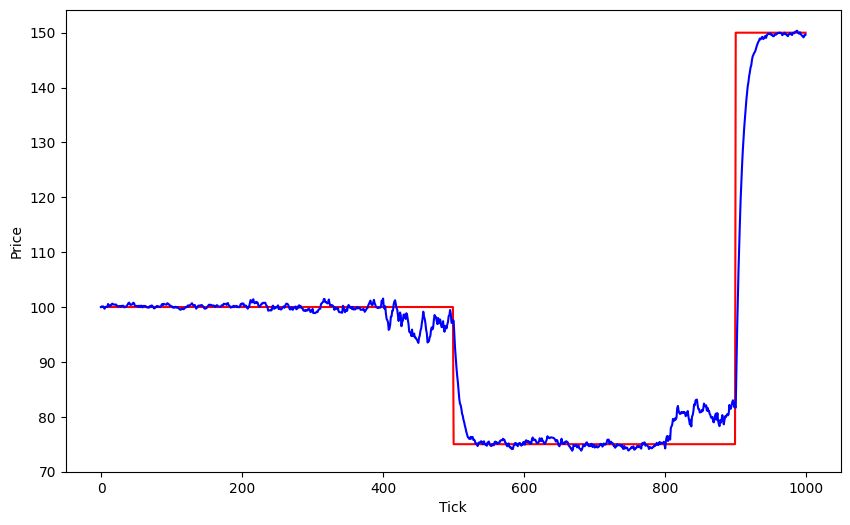

In [10]:
def volatility_strength_func(tick: int, t: float, dt: float):
    if 0 <= tick < 200:
        return 0.5
    elif 200 <= tick < 400:
        return 1.0
    elif 400 <= tick < 500:
        return 2.5
    elif 500 <= tick < 800:
        return 1
    elif 800 <= tick < 900:
        return 2.5
    else:
        return 0.5

def reversion_strength_func(tick: int, t: float, dt: float):
    return 100

def leaky_reversion_strength_func(tick: int, t: float, dt: float):
    return 10

base_path = get_base_path(100, 150, 50, TOTAL_TICKS, EXTRA_TICKS, 0.5, 0.75, rng)
following_path = leaky_mean_reverting_follower(
    base_path, volatility_strength_func, reversion_strength_func, 
    EXTRA_TICKS, leaky_reversion_strength_func, TOTAL_TICKS, 1.0, rng
)
plt.figure(figsize=(10, 6))
plt.plot(base_path[:TOTAL_TICKS], color="red")
plt.plot(following_path[:TOTAL_TICKS], color="blue")
plt.xlabel("Tick")
plt.ylabel("Price")
plt.show()

1001


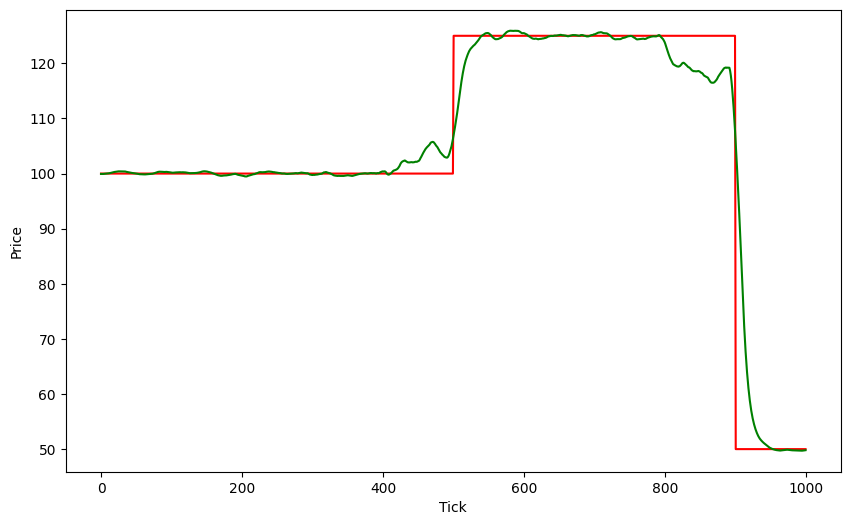

In [11]:
from helpers.Paths import sliding_window_edge_pad 

def volatility_strength_func(tick: int, t: float, dt: float):
    if 0 <= tick < 200:
        return 0.5
    elif 200 <= tick < 400:
        return 1.0
    elif 400 <= tick < 500:
        return 2.5
    elif 500 <= tick < 800:
        return 1.0
    elif 800 <= tick < 900:
        return 2.5
    else:
        return 0.5

def reversion_strength_func(tick: int, t: float, dt: float):
    return 100

def leaky_reversion_strength_func(tick: int, t: float, dt: float):
    return 10

base_path = get_base_path(100, 150, 50, TOTAL_TICKS, EXTRA_TICKS, 0.5, 0.75, rng)
following_path = leaky_mean_reverting_follower(
    base_path, volatility_strength_func, reversion_strength_func, 
    EXTRA_TICKS, leaky_reversion_strength_func, TOTAL_TICKS, 1.0, rng
)
smoothed_path = sliding_window_edge_pad(following_path, 20)
print(len(smoothed_path))
plt.figure(figsize=(10, 6))
plt.plot(base_path[:TOTAL_TICKS], color="red")
plt.plot(smoothed_path[:TOTAL_TICKS], color="green")
plt.xlabel("Tick")
plt.ylabel("Price")
plt.show()

In [12]:
import python_modules.Server as Server

total_steps = TOTAL_TICKS
currency = Server.GenericSecurities.GenericCurrency("CAD")
stock = Server.GenericSecurities.GenericStock("BIOTECH", "CAD")
simulation = Server.GenericSimulation(
    { "CAD": currency, "BIOTECH": stock }, 1.0, total_steps
)
currency_id = simulation.get_security_id("CAD")
stock_id = simulation.get_security_id("BIOTECH")
anon_id = simulation.add_user("AGENT")

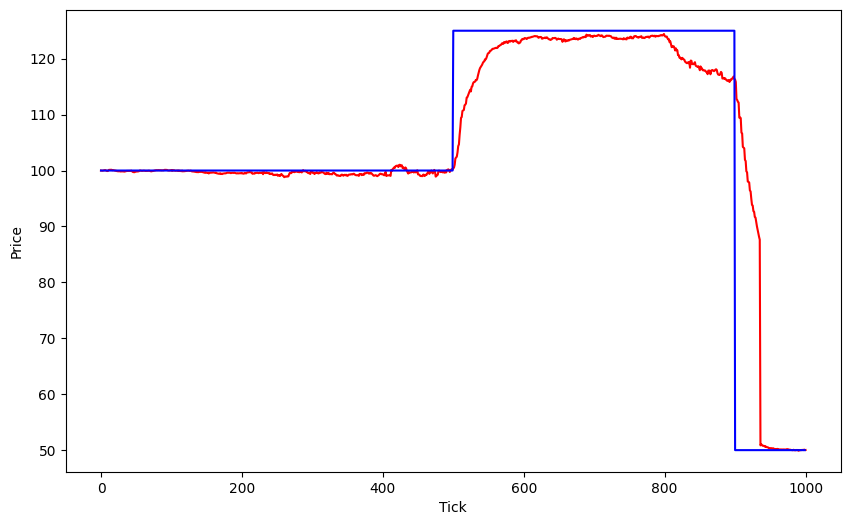

In [13]:
def volatility_strength_func(tick: int, t: float, dt: float):
    if 0 <= tick < 200:
        return 0.5
    elif 200 <= tick < 400:
        return 1.0
    elif 400 <= tick < 500:
        return 2.5
    elif 500 <= tick < 800:
        return 1.0
    elif 800 <= tick < 900:
        return 2.5
    else:
        return 0.5

def reversion_strength_func(tick: int, t: float, dt: float):
    return 100

def leaky_reversion_strength_func(tick: int, t: float, dt: float):
    return 10

simulation.reset_simulation()
base_path = get_base_path(100, 150, 50, TOTAL_TICKS, EXTRA_TICKS + 1, 0.5, 0.75, rng)
stock_midpoints: List[float] = []
order_book_depths: List[tuple[dict[float, float], dict[float, float]]] = []
transaction_count: List[int] = []
removal_percentage = 0.1
done = False
while not done:
    tick = simulation.get_tick()
    t = simulation.get_t()
    dt = simulation.get_dt()
    volatility = volatility_strength_func(tick, t, dt)
    target = base_path[tick]
    future_target = base_path[tick + EXTRA_TICKS]
    reversion = reversion_strength_func(tick, t, dt)
    leaky_reversion = leaky_reversion_strength_func(tick, t, dt)
    SPREAD = 0.02
    ORDER_SIZE_MIN = 1
    ORDER_SIZE_MAX = 25
    
    if tick == 0:
        assert simulation.get_ask_count(stock_id) + simulation.get_ask_count(stock_id) == 0
        
        price_distribution = rng.uniform(0.75, 1.0, size=50)
        volume_distribution = rng.integers(ORDER_SIZE_MIN, ORDER_SIZE_MAX, 50)

        bid_top_price = target - SPREAD
        bid_bottom_price = bid_top_price - 0.1 * volatility * bid_top_price
        bid_prices: List[float] = list(bid_top_price * price_distribution + bid_bottom_price * (1.0 - price_distribution))
        bids = [(Server.OrderSide.BID, price, volume_distribution[i]) for i, price in enumerate(bid_prices)]
        
        ask_bottom_price = target + SPREAD
        ask_top_price = ask_bottom_price + 0.1 * volatility * ask_bottom_price
        ask_prices: List[float] = list(ask_bottom_price * price_distribution + ask_top_price * (1.0 - price_distribution))
        asks = [(Server.OrderSide.ASK, price, volume_distribution[i]) for i, price in enumerate(ask_prices)]

        combined_orders: List[Tuple[Server.OrderSide, float, float]] = bids + asks
        rng.shuffle(combined_orders)

        for (side, price, volume) in combined_orders:
            simulation.direct_insert_limit_order(anon_id, stock_id, side, round(price, 2), volume)
            pass
        pass
    else:
        is_at_large_change = False
        order_count = 5
        
        orders_ANON = list(simulation.get_all_open_user_orders(anon_id, stock_id))
        # Remove some percent of ANON orders
        dynamic_removal_percentage = removal_percentage if not is_at_large_change else 1.25 * removal_percentage
        if (k := int(len(orders_ANON) * removal_percentage)) > 0:
            orders_to_remove = list(rng.choice(a=orders_ANON, size=k, replace=False))
            for order_id in orders_to_remove:
                simulation.submit_cancel_order(anon_id, stock_id, order_id)
                pass
            pass
        
        if simulation.get_bid_count(stock_id) > 0 and simulation.get_ask_count(stock_id) > 0:
            top_bid_price = simulation.get_top_bid(stock_id).price
            top_ask_price = simulation.get_top_ask(stock_id).price
        elif simulation.get_bid_count(stock_id) > 0:
            top_bid_price = simulation.get_top_bid(stock_id).price
            top_ask_price = top_bid_price + 0.5
        elif simulation.get_ask_count(stock_id) > 0:
            top_ask_price = simulation.get_top_ask(stock_id).price
            top_bid_price = top_ask_price + 0.5
        else:
            midpoint = stock_midpoints[-1]
            top_bid_price = midpoint + 0.5
            top_ask_price = midpoint + 0.5
        
        bid_prices = (
            top_bid_price - SPREAD
               + reversion * (target - top_bid_price) * dt
               + leaky_reversion * (future_target - top_bid_price) * dt
               + volatility * np.sqrt(top_bid_price * dt)
               * rng.normal(loc=0.0, scale=1.0, size=order_count)
        )
        bid_quantities = rng.integers(ORDER_SIZE_MIN, ORDER_SIZE_MAX, size=order_count)
        bids = [(Server.OrderSide.BID, price, bid_quantities[i]) for i, price in enumerate(bid_prices)]
        
        ask_prices = (
            top_bid_price + SPREAD
               + reversion * (target - top_ask_price) * dt
               + leaky_reversion * (future_target - top_ask_price) * dt
               + volatility * np.sqrt(top_ask_price * dt)
               * rng.normal(loc=0.0, scale=1.0, size=order_count)
        )
        ask_quantities = rng.integers(ORDER_SIZE_MIN, ORDER_SIZE_MAX, size=order_count) 
        asks = [(Server.OrderSide.ASK, price, ask_quantities[i]) for i, price in enumerate(ask_prices)]
        
        combined_orders: List[Tuple[Server.OrderSide, float, float]] = bids + asks
        rng.shuffle(combined_orders)

        for (side, price, volume) in combined_orders:
            simulation.submit_limit_order(anon_id, stock_id, side, round(price, 2), volume)
            pass
        pass
    
    results = simulation.do_simulation_step()
    
    if simulation.get_bid_count(stock_id) > 0 and simulation.get_ask_count(stock_id) > 0:
        top_bid_price = simulation.get_top_bid(stock_id).price
        top_ask_price = simulation.get_top_ask(stock_id).price
    elif simulation.get_bid_count(stock_id) > 0:
        top_bid_price = simulation.get_top_bid(stock_id).price
        top_ask_price = top_bid_price + 0.5
    elif simulation.get_ask_count(stock_id) > 0:
        top_ask_price = simulation.get_top_ask(stock_id).price
        top_bid_price = top_ask_price + 0.5
    else:
        top_bid_price = stock_midpoints[-1] - 0.5
        top_ask_price = stock_midpoints[-1] + 0.5
    stock_midpoints.append((top_bid_price + top_ask_price) / 2.0)
    order_book_depths.append(results.order_book_depth_per_security["BIOTECH"])
    transaction_count.append(len(results.transactions["BIOTECH"]))
    
    done = not results.has_next_step
    pass

plt.figure(figsize=(10, 6))
plt.plot(stock_midpoints, color="red")
plt.plot(base_path[:TOTAL_TICKS], color="blue")
plt.xlabel("Tick")
plt.ylabel("Price")
plt.show()

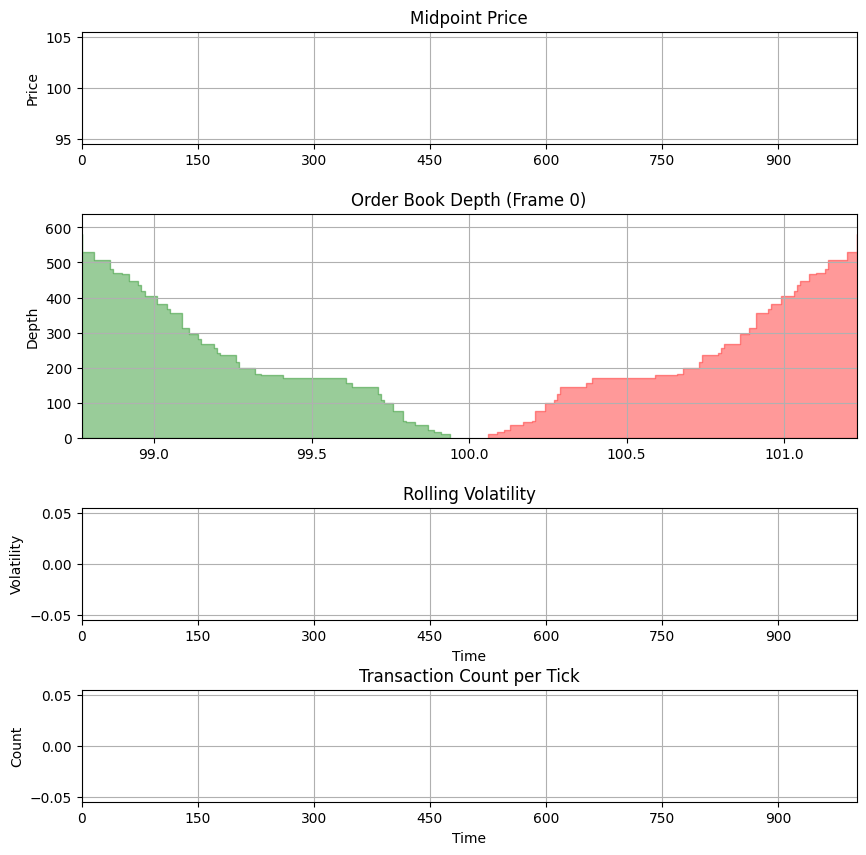

In [14]:
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker

midpoints_np = np.array(stock_midpoints)
midpoints_diffed = np.diff(midpoints_np)
window = 20  # rolling window
rolling_volatility = np.concatenate([
    [np.nan] * (window - 1),
    [np.std(midpoints_diffed[i-window+1:i+1]) for i in range(window-1, len(midpoints_diffed))]
])

# Set up figure with 3 rows: midpoint, depth chart, volatility
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 1, height_ratios=[1, 2, 1, 1], hspace=0.5)  # extra space between plots
ax_mid = fig.add_subplot(gs[0])
ax_depth = fig.add_subplot(gs[1])
ax_vol = fig.add_subplot(gs[2])
ax_txn = fig.add_subplot(gs[3])

def animate(i):
    ax_mid.clear()
    ax_depth.clear()
    ax_vol.clear()
    ax_txn.clear()

    # --- MIDPOINT AXIS ---
    ax_mid.plot(stock_midpoints[:i+1], color='black')
    ax_mid.set_title("Midpoint Price")
    ax_mid.set_ylabel("Price")
    ax_mid.set_xlim(0, len(stock_midpoints))
    ax_mid.grid(True)

    # --- DEPTH CHART AXIS ---
    bids, asks = order_book_depths[i]
    bid_prices = sorted(bids.keys(), reverse=True)
    ask_prices = sorted(asks.keys())

    bid_depths = [bids[p] for p in bid_prices]
    ask_depths = [asks[p] for p in ask_prices]

    ax_depth.fill_between(bid_prices, bid_depths, color='green', alpha=0.4, step='post', label='Bids')
    ax_depth.fill_between(ask_prices, ask_depths, color='red', alpha=0.4, step='post', label='Asks')

    ax_depth.set_title(f"Order Book Depth (Frame {i})")
    ax_depth.set_ylabel("Depth")
    ax_depth.set_xlim(min(bid_prices + ask_prices), max(bid_prices + ask_prices))
    ax_depth.set_ylim(0, max(bid_depths + ask_depths) * 1.1)
    ax_depth.grid(True)

    # --- VOLATILITY AXIS ---
    ax_vol.plot(rolling_volatility[:i+1], color='blue')
    ax_vol.set_title("Rolling Volatility")
    ax_vol.set_ylabel("Volatility")
    ax_vol.set_xlabel("Time")
    ax_vol.set_xlim(0, len(stock_midpoints))
    ax_vol.grid(True)
    
    # --- TRANSACTION COUNT PLOT ---
    ax_txn.plot(transaction_count[:i + 1], color='purple')
    ax_txn.set_title("Transaction Count per Tick")
    ax_txn.set_ylabel("Count")
    ax_txn.set_xlabel("Time")
    ax_txn.set_xlim(0, len(transaction_count))
    ax_txn.grid(True)

    # Improve ticks
    ax_mid.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax_vol.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax_txn.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

ani = FuncAnimation(fig, animate, frames=len(stock_midpoints), interval=200)
ani.save("./simulation_case_00_biotech.mp4", fps=30, extra_args=['-vcodec', 'libx264'])